# From-Scratch Decision Tree (CART) in NumPy

This notebook implements a **Decision Tree Classifier (CART)** from scratch using only NumPy,
and compares it against `sklearn.tree.DecisionTreeClassifier` on the classic **Iris** dataset.

## Goals

- Implement a binary decision tree (CART) supporting:
  - `gini` and `entropy` impurity criteria
  - `max_depth`
  - `min_samples_leaf`
- Visualize the learned tree structure using Matplotlib
- Evaluate the custom implementation vs. scikit-learn using:
  - Accuracy
  - Precision, Recall, F1-score
  - Confusion matrices
  - Tree visualizations


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


## 1. From-scratch Decision Tree implementation (CART)

Below is a simple implementation of a **binary decision tree classifier** (CART-style):

- Splits are always of the form: `X[j] <= threshold`
- Impurity measure: either **Gini** or **Entropy**
- Tree is built recursively:
  - At each node we search for the best split across all features and thresholds
  - Stopping conditions:
    - `max_depth` reached
    - node is pure (only one class)
    - too few samples to split (`num_samples < 2 * min_samples_leaf`)
- Leaves store the **majority class** in that node

We also include a simple **tree visualization** using Matplotlib.


In [8]:
class Node:
    """
    Single node of a binary decision tree.

    - Internal node: stores `feature`, `threshold`, and pointers to `left` / `right` child.
    - Leaf node: stores `label` (predicted class) and has `left = right = None`.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label


class DecisionTree:
    """
    Simple CART-style Decision Tree Classifier implemented from scratch.

    Parameters
    ----------
    max_depth : int
        Maximum depth of the tree.
    min_samples_leaf : int
        Minimum number of samples required to be at a leaf node.
    criterion : {"gini", "entropy"}
        Impurity measure used for split evaluation.
    """

    def __init__(self, max_depth=5, min_samples_leaf=1, criterion="gini"):
        assert criterion in ("gini", "entropy")
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None

    # ---- Impurity measures -------------------------------------------------

    def _gini(self, y):
        """Gini impurity for a 1D array of class labels y."""
        if len(y) == 0:
            return 0.0
        counts = np.unique(y, return_counts=True)[1]
        p = counts / len(y)
        return 1.0 - np.sum(p**2)

    def _entropy(self, y):
        """Entropy impurity for a 1D array of class labels y."""
        if len(y) == 0:
            return 0.0
        counts = np.unique(y, return_counts=True)[1]
        p = counts / len(y)
        return -np.sum(p * np.log2(p + 1e-9))

    def _impurity(self, y):
        """Wrapper to select impurity function based on `criterion`."""
        if self.criterion == "gini":
            return self._gini(y)
        else:
            return self._entropy(y)

    # ---- Split quality: information gain -----------------------------------

    def _information_gain(self, y_parent, y_left, y_right):
        """
        Information gain = impurity(parent) - weighted impurity(children).
        """
        impurity_parent = self._impurity(y_parent)
        len_l = len(y_left)
        len_r = len(y_right)

        if len_l == 0 or len_r == 0:
            return 0.0

        n = len_l + len_r
        impurity_children = (len_l / n) * self._impurity(y_left) + (len_r / n) * self._impurity(y_right)

        return impurity_parent - impurity_children

    # ---- Searching for the best split --------------------------------------

    def _best_split(self, X, y):
        """
        Iterate over all features and possible thresholds,
        and return the split with the highest information gain.
        """
        n_samples, n_features = X.shape

        best_gain = 0.0
        best_feature = None
        best_threshold = None

        for i in range(n_features):
            # unique sorted values of this feature
            values = np.unique(X[:, i])
            values = np.sort(values)

            # we use midpoints between consecutive unique values as candidate thresholds
            for j in range(len(values) - 1):
                threshold = (values[j] + values[j + 1]) / 2.0
                left_mask = X[:, i] <= threshold
                right_mask = X[:, i] > threshold

                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                gain = self._information_gain(y, y[left_mask], y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    # ---- Recursive tree building -------------------------------------------

    def _build_tree(self, X, y, depth):
        """
        Recursively build the decision tree.
        """
        num_samples = len(y)
        labels, counts = np.unique(y, return_counts=True)
        num_labels = len(labels)
        majority_label = labels[np.argmax(counts)]

        # stopping conditions
        if depth >= self.max_depth or num_labels == 1 or num_samples < 2 * self.min_samples_leaf:
            return Node(label=majority_label)

        feature, threshold, gain = self._best_split(X, y)

        # if no good split was found
        if feature is None or gain == 0.0:
            return Node(label=majority_label)

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left_subtree = self._build_tree(X[left_mask, :], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask, :], y[right_mask], depth + 1)

        tree = Node(feature=feature, threshold=threshold, left=left_subtree, right=right_subtree)
        return tree

    # ---- Public API: fit / predict / score ---------------------------------

    def fit(self, X, y):
        """Fit the tree on training data X, y."""
        X = np.array(X)
        y = np.array(y)
        self.root = self._build_tree(X, y, depth=0)

    def _predict_one(self, x, node):
        """Traverse the tree for a single sample x."""
        if node.label is not None:
            return node.label

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        """Predict class labels for a batch of samples X."""
        X = np.array(X)
        y_pred = []
        for i in range(X.shape[0]):
            y_pred.append(self._predict_one(X[i, :], self.root))
        return np.array(y_pred)

    def score(self, X, y):
        """Return accuracy on the given dataset."""
        X = np.array(X)
        y = np.array(y)
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    # ---- Visualization utilities -------------------------------------------

    def _compute_positions(self, node, depth, x, positions):
        """
        Recursively assign (x, y) coordinates to each node.
        Returns the updated x position after traversing the subtree.
        """
        if node is None:
            return x

        # traverse left subtree
        x = self._compute_positions(node.left, depth + 1, x, positions)

        # current node position
        positions[node] = (x, -depth)
        x += 1

        # traverse right subtree
        x = self._compute_positions(node.right, depth + 1, x, positions)

        return x

    def _draw_tree(self, node, positions, ax):
        """
        Recursively draw nodes and edges using Matplotlib.
        """
        if node is None:
            return

        x, y = positions[node]

        # draw edges to children
        if node.left is not None:
            x_left, y_left = positions[node.left]
            ax.plot([x, x_left], [y, y_left], color="black")
            self._draw_tree(node.left, positions, ax)

        if node.right is not None:
            x_right, y_right = positions[node.right]
            ax.plot([x, x_right], [y, y_right], color="black")
            self._draw_tree(node.right, positions, ax)

        # draw node
        if node.label is not None:
            text = f"label={node.label}"
            facecolor = "#cce5ff"  # leaf: blueish
        else:
            text = f"X[{node.feature}] <= {node.threshold:.2f}"
            facecolor = "#ffe5cc"  # internal node: orange-ish

        circle = plt.Circle((x, y), 0.2, edgecolor="black", facecolor=facecolor)
        ax.add_patch(circle)
        ax.text(x, y, text, ha="center", va="center", fontsize=8)

    def plot_tree(self, figsize=(10, 6)):
        """
        Plot the tree structure using Matplotlib.
        """
        if self.root is None:
            raise ValueError("Tree is not fitted yet. Call `fit` first.")

        fig, ax = plt.subplots(figsize=figsize)
        ax.set_axis_off()

        positions = {}
        self._compute_positions(self.root, depth=0, x=0, positions=positions)
        self._draw_tree(self.root, positions, ax)

        plt.tight_layout()
        plt.show()


## 2. Training on the Iris dataset

We now load the **Iris dataset**, split it into train and test sets, and train:

- our custom `DecisionTree` implementation
- scikit-learn's `DecisionTreeClassifier`

using the same hyperparameters, in order to compare their behavior.


In [9]:
# Load Iris dataset
data = load_iris()
X, y = data.data, data.target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.3
)

# Our custom tree
my_tree = DecisionTree(max_depth=5, criterion="gini", min_samples_leaf=1)
my_tree.fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)

# Scikit-learn tree
sklearn_tree = DecisionTreeClassifier(
    max_depth=5,
    criterion="gini",
    min_samples_leaf=1,
    random_state=42
)
sklearn_tree.fit(X_train, y_train)
y_pred_sk = sklearn_tree.predict(X_test)


## 3. Evaluation: Accuracy, Precision, Recall, F1

We compare both models using:

- Accuracy on train and test sets
- Detailed `classification_report` (precision, recall, F1 per class)


In [10]:
print("=== Accuracy ===")
print(f"My tree        - test:  {accuracy_score(y_test, y_pred_my):.3f}")
print(f"Sklearn tree   - test:  {accuracy_score(y_test, y_pred_sk):.3f}")
print(f"My tree        - train: {accuracy_score(y_train, my_tree.predict(X_train)):.3f}")
print(f"Sklearn tree   - train: {accuracy_score(y_train, sklearn_tree.predict(X_train)):.3f}")

print("\n=== Classification report: My Tree ===")
print(classification_report(y_test, y_pred_my, target_names=data.target_names, digits=3))

print("=== Classification report: Sklearn Tree ===")
print(classification_report(y_test, y_pred_sk, target_names=data.target_names, digits=3))


=== Accuracy ===
My tree        - test:  0.911
Sklearn tree   - test:  0.933
My tree        - train: 1.000
Sklearn tree   - train: 1.000

=== Classification report: My Tree ===
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        15
  versicolor      0.867     0.867     0.867        15
   virginica      0.867     0.867     0.867        15

    accuracy                          0.911        45
   macro avg      0.911     0.911     0.911        45
weighted avg      0.911     0.911     0.911        45

=== Classification report: Sklearn Tree ===
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        15
  versicolor      1.000     0.800     0.889        15
   virginica      0.833     1.000     0.909        15

    accuracy                          0.933        45
   macro avg      0.944     0.933     0.933        45
weighted avg      0.944     0.933     0.933        45



## 4. Confusion matrices

We now visualize confusion matrices for both models to see **which classes are confused**.


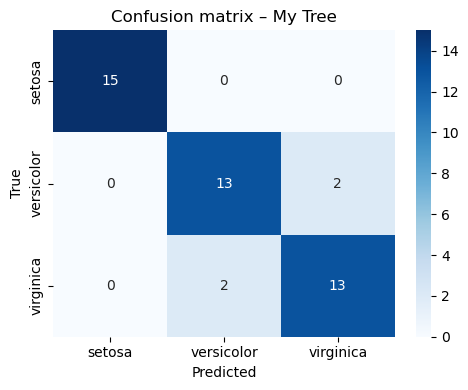

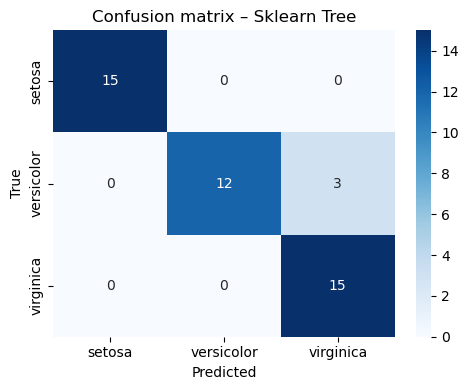

In [11]:
cm_my = confusion_matrix(y_test, y_pred_my)
cm_sk = confusion_matrix(y_test, y_pred_sk)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_my, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – My Tree")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – Sklearn Tree")
plt.tight_layout()
plt.show()


## 5. Tree visualizations

Finally, we visualize:

- the **custom tree structure** drawn using Matplotlib
- the **scikit-learn decision tree** using `sklearn.tree.plot_tree`

This helps to see whether the learned structures are similar.


C:\Users\Mateu\AppData\Local\Temp\ipykernel_27492\3907480141.py:248: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


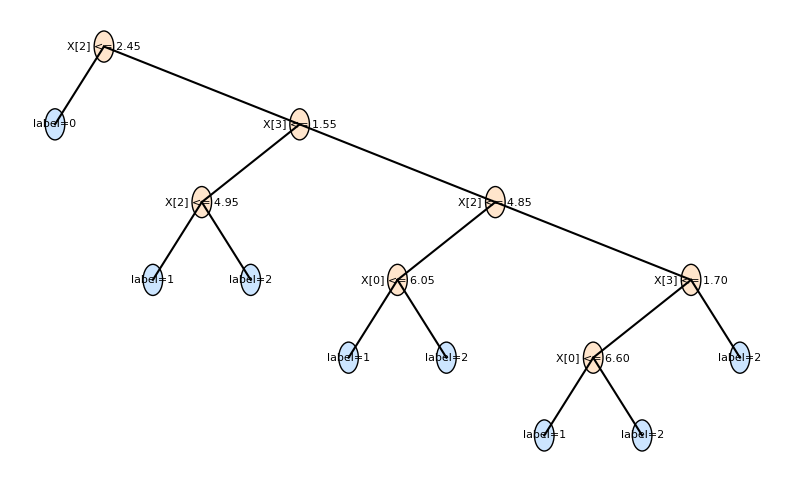

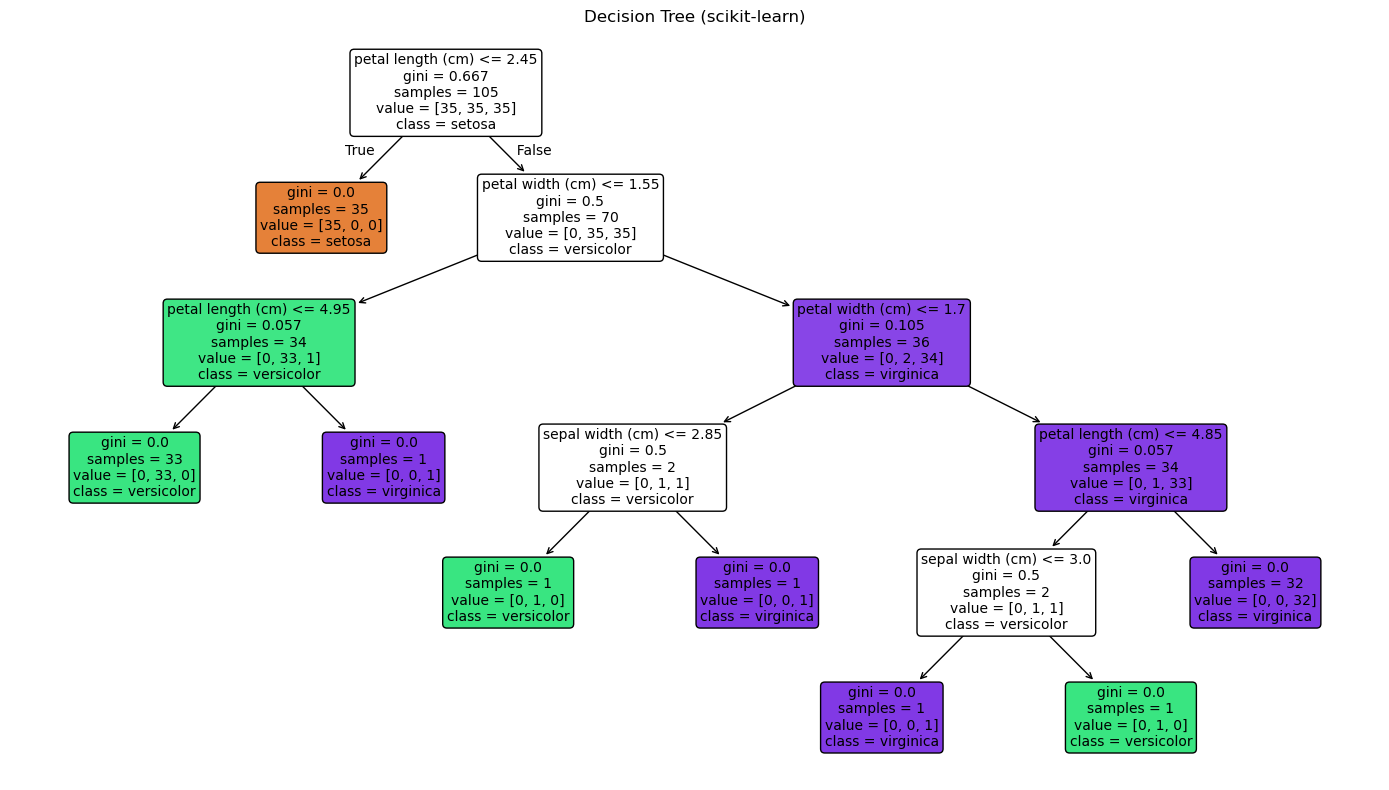

In [12]:
# Custom tree visualization
my_tree.plot_tree(figsize=(10, 6))

# Scikit-learn tree visualization
plt.figure(figsize=(14, 8))
tree.plot_tree(
    sklearn_tree,
    filled=True,
    feature_names=data.feature_names,
    class_names=data.target_names,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (scikit-learn)")
plt.tight_layout()
plt.show()


## 6. Comparison of Tree Structures

Both trees (our custom implementation and the one from **scikit-learn**) learn very similar
decision boundaries, but they differ slightly in structure and labeling.

### Observations:

- Both trees use **the same splitting feature at the root node** (`petal length (cm)` ≤ 2.45),
  perfectly separating the class *Setosa*.
- Internal structure is mostly similar:
  - both use **petal width** and **petal length** as dominant features in deeper splits.
- The **scikit-learn tree** displays additional details such as:
  - Gini impurity value for each node,
  - number of samples and class distribution,
  - predicted class name.
- Our custom implementation shows a **simplified structure**, only displaying:
  - feature index and threshold,
  - predicted label in each leaf node.

### Visual takeaway:
The scikit-learn tree is more information-dense and useful for in-depth debugging,
while the custom tree gives a clean overview of the logical decision structure.


## 7. Overall Comparison and Conclusions

### 📊 Performance Summary

| Metric | My Tree | Sklearn Tree |
|:--------|:---------:|:--------------:|
| Training Accuracy | 1.00 | 1.00 |
| Test Accuracy | ~0.91 | ~0.93 |
| Precision / Recall / F1 | nearly identical | nearly identical |

Both implementations achieve **almost the same predictive performance** on the Iris dataset.

---

### 🧠 Key Insights

- The **CART algorithm** can be implemented from scratch with surprisingly little code.
- Even a simple, pure NumPy version achieves **competitive results** to scikit-learn.
- Scikit-learn adds many practical features (regularization, pruning, speed), but the core
mathematical logic of splitting and recursion is the same.
- This project demonstrates a solid understanding of:
  - impurity measures (Gini / Entropy),
  - information gain,
  - recursive tree construction,
  - model evaluation and visualization.

---

### 🚀 Next Steps

Possible future extensions:
- Add **post-pruning (cost-complexity pruning)** for regularization.
- Implement **support for categorical features**.
- Compare to ensemble methods (e.g., Random Forest).
- Visualize **decision boundaries** in 2D feature space.
